## Ridgecrest seismicity map
original from: https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy


## Version of python modules

In [1]:
import numpy as np
import cartopy as cp
import matplotlib as mpl
import pandas as pd


print("# numpy version = ",np.__version__)
print("# cartopy version = ",cp.__version__)
print("# matplotlib version = ",mpl.__version__)
print("# pandas version = ",pd.__version__)


# numpy version =  1.19.1
# cartopy version =  0.18.0
# matplotlib version =  3.3.1
# pandas version =  1.0.4


## Import numpy, cartopy, matplotlib and etc

In [2]:
import csv
import numpy as np
import cartopy.crs as ccrs

import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from obspy.imaging.beachball import beach

import io
from urllib.request import urlopen, Request
from PIL import Image


## function: image_spoof
This may not need for our RC seismic map...

In [3]:
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy



## Reading station lat & lon file
This file only includes CI broadband sites within 100km from the Ridgecrest M7.1 event. These are currently used for our eGF project.

In [4]:
sta_loc_fi = "http://ncedc.org/ftp/outgoing/taira/RC/ci_bb_sta.txt"
#CCC 3.552495e+01 -1.173645e+02
sta_loc = pd.read_csv(sta_loc_fi, skiprows=None,
                       sep=" ",names=["stname", "stla", "stlo" ],header=None)

print(sta_loc)

   stname      stla      stlo
0     CCC  35.52495 -117.3645
1     CLC  35.81574 -117.5975
2     DAW  36.27148 -117.5921
3    JRC2  35.98249 -117.8089
4     LRL  35.47954 -117.6821
5     MPM  36.05799 -117.4890
6     SLA  35.89095 -117.2833
7     SRT  35.69235 -117.7505
8    TOW2  35.80856 -117.7649
9     WBM  35.60839 -117.8905
10    WBS  35.53664 -118.1404
11   WCS2  36.02521 -117.7653
12    WMF  36.11758 -117.8549
13    WOR  35.69563 -118.2425
14   WRC2  35.94790 -117.6504


## Reading relocated catalog
use David Shelly's reolocated catalog.


In [5]:
#cat srl-2019309_supplement_hypos_ridgecrest_srl_header_mnew.txt | awk '{if($1!="#")print $1" "$2" "$3" "$4" "$5" "$6" "$7" "$8" "$9" "$10" "$11" "$12" "$13" "$14}' >! ds_catalog.txt
# File format:  YYYY MM dd hh mm ss.sss lat lon depth x y z mag ID
# 2019 07 04 15 35 29.400   35.708036 -117.499365  12.527     6666.900    -6648.100     5735.400   0.17   70456129
#ds_catalog_fi = "srl-2019309_supplement_hypos_ridgecrest_srl_header_mnew.txt"
#ds_catalog_fi = "ds_catalog.txt"
ds_catalog_fi = "http://ncedc.org/ftp/outgoing/taira/RC/ds_catalog.txt"

ds_catalog = pd.read_csv(ds_catalog_fi, skiprows=None,
                       sep=" ",names=["year", "month", "day", "hour", "min", "sec", "evla", "evlo", "dep", "x", "y", "z", "mag", "ID"],header=None)

print(ds_catalog)

       year  month  day  hour  min    sec       evla        evlo     dep  \
0      2019      7    4    15   35  29.40  35.708036 -117.499365  12.527   
1      2019      7    4    15   42  47.90  35.708040 -117.499382  12.508   
2      2019      7    4    16    7  19.95  35.708081 -117.499430  12.517   
3      2019      7    4    16   13  11.39  35.707955 -117.499211  12.506   
4      2019      7    4    16   13  43.16  35.708044 -117.499382  12.495   
...     ...    ...  ...   ...  ...    ...        ...         ...     ...   
34086  2019      7   16    23   57  49.40  35.564864 -117.438566   3.404   
34087  2019      7   16    23   58   3.04  35.936633 -117.725643   2.841   
34088  2019      7   16    23   58  44.68  35.975981 -117.667220   3.593   
34089  2019      7   16    23   58  53.00  35.878149 -117.686279   3.453   
34090  2019      7   16    23   59  26.50  35.847689 -117.676628   5.038   

             x        y       z   mag        ID  
0       6666.9  -6648.1  5735.4  0.17

## Selecting M>=2.0 events

In [6]:
minmag = 2.0
catalog_select = ds_catalog[(ds_catalog['mag']  >=  minmag)]
print(catalog_select)

       year  month  day  hour  min    sec       evla        evlo     dep  \
6      2019      7    4    17    2  55.32  35.710136 -117.500179  12.286   
12     2019      7    4    17    9  20.00  35.709648 -117.499463  12.435   
15     2019      7    4    17   12  14.70  35.708114 -117.499284  11.876   
35     2019      7    4    17   33  48.76  35.708350 -117.498625  15.054   
36     2019      7    4    17   35   1.64  35.643070 -117.557894  10.229   
...     ...    ...  ...   ...  ...    ...        ...         ...     ...   
33955  2019      7   16    22   31  33.30  35.643433 -117.450309   4.060   
33967  2019      7   16    22   38  43.30  35.778442 -117.588737   3.338   
33970  2019      7   16    22   40  21.68  35.634831 -117.480233  11.414   
34010  2019      7   16    23   11  27.32  35.568844 -117.391341   4.815   
34060  2019      7   16    23   43   3.60  35.794649 -117.624105   3.095   

             x        y       z   mag        ID  
6       6593.4  -6415.2  5494.0  3.98

## Plotting M>2 events, focal mechanisms for M7.1 & M6.4, and M5.4 (our working event) events, and seismic stations 

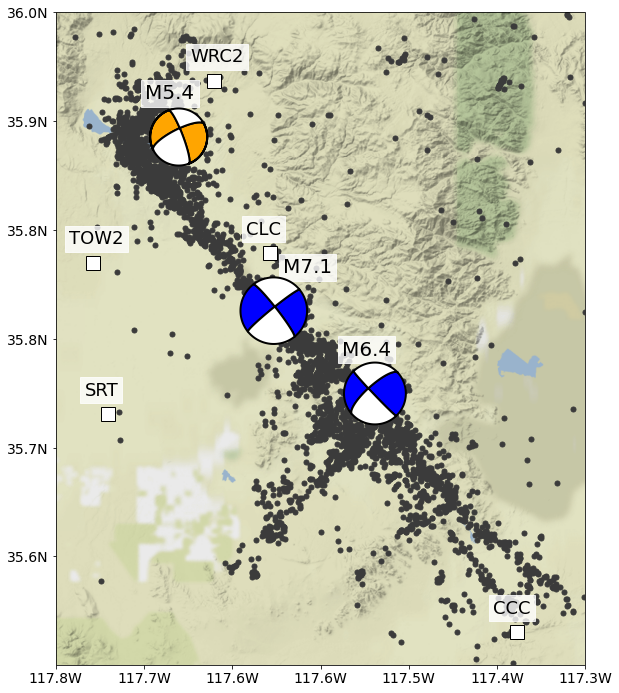

In [7]:

#######################################
# Formatting the Cartopy plot
#######################################
#
cimgt.Stamen.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.Stamen('terrain-background') # spoofed, downloaded street map

# figure size
fig = plt.figure(figsize=(14,12)) # open matplotlib figure
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map



## map 
lonmin = -117.8
lonmax = -117.3
latmin = 35.5
latmax = 36.0
#extent = [-117.8, -117.3, 35.5, 36.0] # RC bounds
extent = [lonmin, lonmax, latmin, latmax] # RC bounds



ax1.set_extent(extent) # set extents
ax1.set_xticks(np.linspace(extent[0],extent[1],7),crs=ccrs.PlateCarree()) # set longitude indicators
ax1.set_yticks(np.linspace(extent[2],extent[3],7)[1:],crs=ccrs.PlateCarree()) # set latitude indicators

lon_formatter = LongitudeFormatter(number_format='0.1f',degree_symbol='',dateline_direction_label=True) # format lons
lat_formatter = LatitudeFormatter(number_format='0.1f',degree_symbol='') # format lats

ax1.xaxis.set_major_formatter(lon_formatter) # set lons
ax1.yaxis.set_major_formatter(lat_formatter) # set lats
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

scale = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2.0,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax1.add_image(osm_img, int(scale)) # add OSM with zoom specification


#######################################
# Plot events and stations
#######################################
#

crs_latlon = ccrs.PlateCarree()

#ax1.plot(lons, lats, markersize=5,marker='o',linestyle='',color='#3b3b3b',transform=ccrs.PlateCarree())

# plot selected events
ax1.plot(catalog_select['evlo'], catalog_select['evla'], markersize=5,marker='o',linestyle='',color='#3b3b3b',transform=ccrs.PlateCarree())

# plot station
ax1.plot(sta_loc['stlo'], sta_loc['stla'], markersize=14,marker='s',markeredgecolor="black", linestyle='',color='white',transform=ccrs.PlateCarree())

#catalog_select = ds_catalog[(ds_catalog['mag']  >=  minmag)]
#sta_loc_select = sta_loc[ (lonmin <= sta_loc["stlo"] & sta_loc["stlo"] <= lomax    )      ]
sta_loc_select = sta_loc[ (lonmin <= sta_loc["stlo"]) & (sta_loc["stlo"] <= lonmax)  & (latmin <= sta_loc["stla"]) & (sta_loc["stla"] <= latmax)      ]
#print(sta_loc_select)
select_index = sta_loc_select['stlo'].index
#for i in range(len(sta_loc['stname'])):
for i in range(len(select_index)):
    i2 = select_index[i]
    #print("# i2 = ", i2)
    #print(sta_loc_select['stname'][i2])
    
    at_x, at_y = ax1.projection.transform_point(sta_loc_select['stlo'][i2], sta_loc_select['stla'][i2], src_crs=crs_latlon)
    t=ax1.text(at_x-2500, at_y+2000, sta_loc_select['stname'][i2], fontsize="18")
    t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))


### focal mech. for tje M7.1 event
# 2019 07 06 03 19 52.860 35.771818 -117.594157 3.241 -1907.800 428.800 -3550.900 7.10 70611993
np1_m71 = [322, 81, -173] # USGS solution # https://earthquake.usgs.gov/earthquakes/eventpage/ci38457511/moment-tensor
lon_m71 = -117.594157 # DS location
lat_m71 = 35.771818 # DS location
size_m71 = 7000 # a bit arbitrary
at_x, at_y = ax1.projection.transform_point(lon_m71, lat_m71, src_crs=crs_latlon)


t=ax1.text(at_x+1000, at_y+4000, "M7.1", fontsize="20")
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))


#print("# at_x = ",at_x," at_y = ",at_y)
beach1 = beach(np1_m71, xy=(at_x, at_y), width=size_m71, linewidth=2, facecolor='b',)
ax1.add_collection(beach1) 

# M6.4
#2019 07 04 17 33 48.760 35.708350 -117.498625 15.054 6734.000 -6613.100 8262.400 6.40 70463229
np1_m64 = [228, 66, 4] # USGS solution # https://earthquake.usgs.gov/earthquakes/eventpage/ci38443183/moment-tensor
lon_m64 = -117.498625 # DS location
lat_m64 = 35.708350 # DS location
size_m64 = 6500 # a bit arbitrary
at_x, at_y = ax1.projection.transform_point(lon_m64, lat_m64, src_crs=crs_latlon)

t=ax1.text(at_x-3500, at_y+4000, "M6.4", fontsize="20")
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

#print("# at_x = ",at_x," at_y = ",at_y)
beach1 = beach(np1_m64, xy=(at_x, at_y), width=size_m64, linewidth=2, facecolor='b',)
ax1.add_collection(beach1) 

# M5.4 (working event), orange
#2019 07 06 04 18 55.800 35.904789 -117.683976 13.805 -10020.800 15182.600 7012.900 5.44 70615536
np1_m54 = [243, 66, -15] # USGS solution # https://earthquake.usgs.gov/earthquakes/eventpage/ci38457847/moment-tensor
lon_m54 = -117.683976 # DS location
lat_m54 = 35.904789# DS location
size_m54 = 6000 # a bit arbitrary
at_x, at_y = ax1.projection.transform_point(lon_m54, lat_m54, src_crs=crs_latlon)

t=ax1.text(at_x-3500, at_y+4000, "M5.4", fontsize="20")
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

#print("# at_x = ",at_x," at_y = ",at_y)
beach1 = beach(np1_m54, xy=(at_x, at_y), width=size_m54, linewidth=2, facecolor="orange",)
ax1.add_collection(beach1) 

# change dpi if needed
plt.savefig("RC_map.png", dpi=150)

# for jpg
#plt.savefig("RC_map.jpg", dpi=150)
# for PDF
#plt.savefig("RC_map.pdf", dpi=150)

#plt.show()
